In [1]:
import gym
import random
import numpy as np
import tensorflow as tf

from collections import deque
from IPython.display import clear_output
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
env = gym.make("CartPole-v1")

In [3]:
os_size = env.observation_space.shape[0]

print(f"Observation Space Size: {os_size}")
print(f"Observation Space Low : {env.observation_space.low}")
print(f"Observation Space High: {env.observation_space.high}")

print(f"\nAction Space: {env.action_space}")

Observation Space Size: 4
Observation Space Low : [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Observation Space High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]

Action Space: Discrete(2)


In [4]:
class Estimator:
    def __init__(self):
        self.model = Sequential()
        
        self.model.add(Dense(16, input_shape=(os_size,), activation="relu"))
        self.model.add(Dense(16, activation="relu"))
        self.model.add(Dense(env.action_space.n, activation="linear"))
        
        self.optimizer = tf.keras.optimizers.Adam(lr=0.001)
        self.model.compile(optimizer=self.optimizer, 
                           loss="mse")
        
        self.model.summary()
        
    def preprocess(self, s):
        state = s.reshape(-1, os_size)
        
        return state
        
    def predict(self, s):
        state = self.preprocess(s)
        
        return self.model.predict(state)
    
    def update(self, s, a, y):
        state = self.preprocess(s)
        
        td_target = self.predict(s)
        td_target[0][a] = y
        
        self.model.fit(state, td_target, verbose=0)
        
    def save(self):
        self.model.save("./models/final.model")

In [5]:
estimator = Estimator()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [6]:
def getEpsilonGreedyPolicy(estimator, nA):
    def policy(state, epsilon):
        A = np.ones(nA) * (epsilon / nA)
        best_action = np.argmax(estimator.predict(state))
        A[best_action] = A[best_action] + (1 - epsilon)
        
        return A
    return policy

In [7]:
def QLearning(env, estimator, num_episodes, discount=1.0, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, batch_size=16):
    replay_memory = deque(maxlen=1000000)
    
    policy = getEpsilonGreedyPolicy(estimator, env.action_space.n)
    
    episode_rewards = np.zeros(num_episodes)
    
    for i_episode in range(num_episodes):
        state = env.reset()
        
        if epsilon > epsilon_min:
            epsilon = epsilon * epsilon_decay**i_episode
        else:
            epsilon = epsilon_min
        
        for t in range(200):
#             if (i_episode + 1) % 50 == 0:
#                 env.render()
            
            action_prob = policy(state, epsilon)
            action_pos = [i for i in range(env.action_space.n)]
            action = np.random.choice(action_pos, p=action_prob)
            
            next_state, reward, done, _ = env.step(action)
            
            episode_rewards[i_episode] = episode_rewards[i_episode] + reward
            replay_memory.append([state, action, reward, next_state, done])
            
            if len(replay_memory) > batch_size:
                replay_batch = random.sample(replay_memory, batch_size)
                
                for ss, aa, rr, ns, terminal in replay_batch:
                    td_target = rr
                    
                    if not terminal:
                        best_next_action_value = np.max(estimator.predict(ns))
                        
                        td_target = rr + discount * best_next_action_value
                        
                    estimator.update(ss, aa, td_target)
            
            if done:
                break
                
            state = next_state
        
        clear_output(True)
        print(f"[{i_episode + 1:>5}/{num_episodes:>5}] Episode Total Reward: {episode_rewards[i_episode]}")
            
    env.close()
    
    estimator.save()
    
    return episode_rewards

In [8]:
episode_rewards = QLearning(env, estimator, 100, epsilon_min=0.1)

[  100/  100] Episode Total Reward: 200.0


In [9]:
print("Last 5 Episodes:")
for i, reward in enumerate(episode_rewards[-5:]):
    print(f"[{i + 1:>5}] Total Reward: {reward}")

Last 5 Episodes:
[    1] Total Reward: 200.0
[    2] Total Reward: 200.0
[    3] Total Reward: 200.0
[    4] Total Reward: 200.0
[    5] Total Reward: 200.0


In [10]:
def playEnvOnce(env, estimator):
    state = env.reset()
    
    total_reward = 0
    
    for t in range(500):
        env.render()
        
        action = np.argmax(estimator.predict(state))
        
        next_state, reward, done, _ = env.step(action)
        
        total_reward = total_reward + reward
        
        if done:
            print(f"Total Reward: {total_reward}")
            break
            
        state = next_state
        
    env.close()

In [11]:
playEnvOnce(env, estimator)

Total Reward: 500.0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

monokai = ["#F92672", "#A6E22E", "#66D9EF", "#FD971F", "#272822"]

sns.set_palette(monokai)
sns.set_style("white")

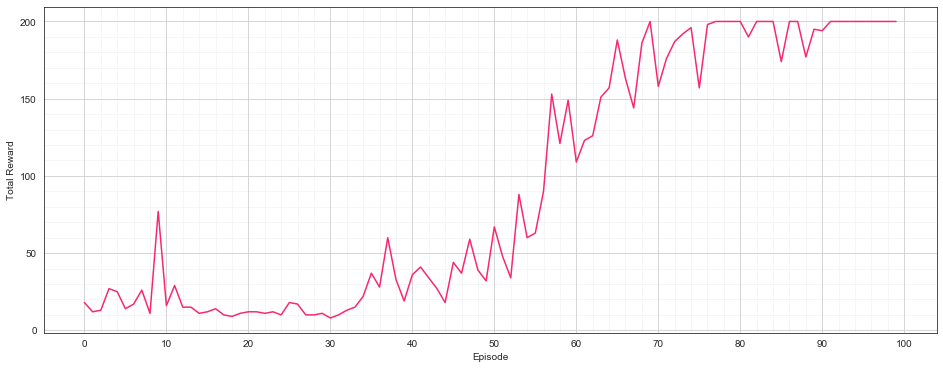

In [13]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_xticks(np.arange(0, 101, 10))
ax.set_xticks(np.arange(0, 101, 2), minor=True)
ax.set_yticks(np.arange(0, 501, 50))
ax.set_yticks(np.arange(0, 501, 10), minor=True)

ax.grid(which="both")
ax.grid(which='minor', alpha=0.2)

plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.plot(episode_rewards)